In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns 
import altair as alt 

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['shops.csv', 'item_categories.csv', 'sales_train.csv', 'items.csv', 'sample_submission.csv', 'test.csv']


# Reading Data

In [2]:
train = pd.read_csv('../input/sales_train.csv')
items = pd.read_csv('../input/items.csv')
categories = pd.read_csv('../input/item_categories.csv')
shops = pd.read_csv('../input/shops.csv')
test = pd.read_csv('../input/test.csv')
submission = pd.read_csv('../input/sample_submission.csv')

In [3]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [4]:
train.shape

(2935849, 6)

In [5]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [6]:
test.shape

(214200, 3)

In [7]:
submission.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


As we can see, the test set is different in size and structure when compared to the training set. We have the features 'shop_id' and 'item_id' in the test set, which are present in the trianing set as well. Each observation in the test set has an ID associated with it. If we look at our submission file, we need to submit the monthly count (item_cnt_month) for that particular ID. This means we need to predict a number for the monthly sale quantity of a particular item at a particular shop.

# EDA

Let's look at the distribution of the training and test set to understand our dataset better and check for overlap, or lack thereof.

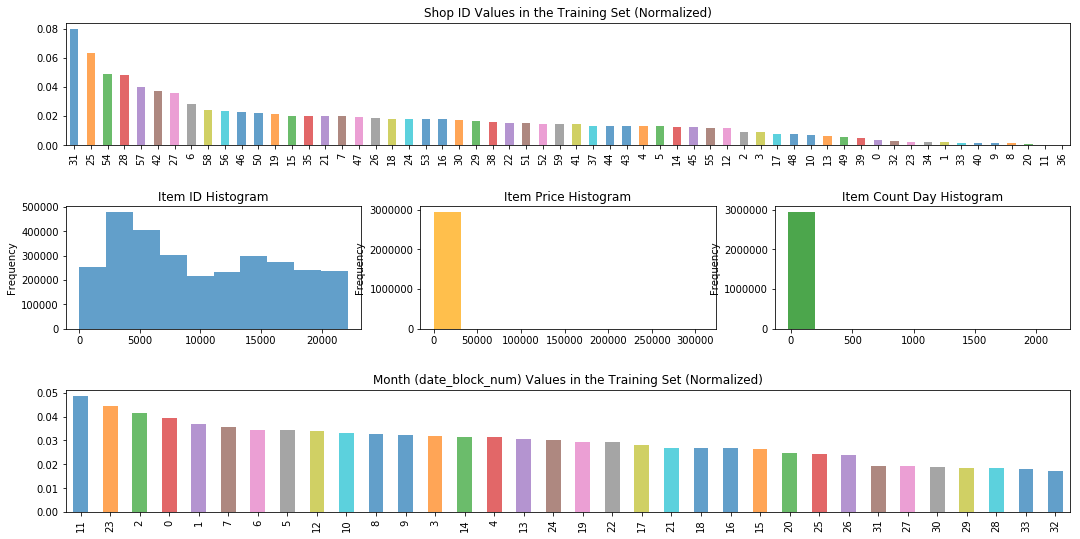

In [8]:
fig = plt.figure(figsize=(18,9))
plt.subplots_adjust(hspace=.5)

plt.subplot2grid((3,3), (0,0), colspan = 3)
train['shop_id'].value_counts(normalize=True).plot(kind='bar', alpha=0.7)
plt.title('Shop ID Values in the Training Set (Normalized)')

plt.subplot2grid((3,3), (1,0))
train['item_id'].plot(kind='hist', alpha=0.7)
plt.title('Item ID Histogram')

plt.subplot2grid((3,3), (1,1))
train['item_price'].plot(kind='hist', alpha=0.7, color='orange')
plt.title('Item Price Histogram')

plt.subplot2grid((3,3), (1,2))
train['item_cnt_day'].plot(kind='hist', alpha=0.7, color='green')
plt.title('Item Count Day Histogram')

plt.subplot2grid((3,3), (2,0), colspan = 3)
train['date_block_num'].value_counts(normalize=True).plot(kind='bar', alpha=0.7)
plt.title('Month (date_block_num) Values in the Training Set (Normalized)')

plt.show()

The above graphs are a nice way to look at the raw distribtion of the test dataset. Here are some observations:

1. We have 60 'shop_id's but there is an uneven distribtution of these in the dataset. Four (<7%) of these shops make up ~25 percent of this dataset. These are shops (31, 25, 54, 28).


2. The Item IDs seem to have variations in frequency. We can't attribute a reason to this yet but we can inspect this further. Certain cateogeries are bound to sell better and maybe items under the same category are closer to each other as far as their ID distributions are concerned


3. From the vast empty spaces in the histograms of 'item_price' and 'item_cnt_day', we can infer that there are outliers in their distribution. **Let's write some simple code below to put a value to these outliers.**


4. Plotting the individual months from January 2013 to October 2015, it is interesting to see that the block month 12, corresponding to December 2013, had the highest number of sales. Month 23, which corresponds to December 2014, had the second highest number of sales. Shortly, we will use some better graphs to observe the monthly sale trends.

## Dealing with Outliers

In [9]:
train['item_id'].value_counts(ascending=False)[:5]

20949    31340
5822      9408
17717     9067
2808      7479
4181      6853
Name: item_id, dtype: int64

Having a look at the item id 20949 that has been sold the most number of times, it is a plastic bag!

In [10]:
items.loc[items['item_id']==20949]

,item_name,item_id,item_category_id
20949,Фирменный пакет майка 1С Интерес белый (34*42)...,20949,71


In [11]:
categories.loc[categories['item_category_id']==71]

,item_category_name,item_category_id
71,"Подарки - Сумки, Альбомы, Коврики д/мыши",71


In [12]:
test.loc[test['item_id']==20949].head(5)

,ID,shop_id,item_id
460,460,5,20949
5560,5560,4,20949
10660,10660,6,20949
15760,15760,3,20949
20860,20860,2,20949


And just to satisfy my curiosity bowels, there is only one item under item category 71 and it is indeed present in the test set!

In [13]:
train['item_cnt_day'].sort_values(ascending=False)[:5]

2909818    2169.0
2326930    1000.0
2864235     669.0
2851091     637.0
2608040     624.0
Name: item_cnt_day, dtype: float64

In [14]:
train[train['item_cnt_day'] == 2169]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2909818,28.10.2015,33,12,11373,0.908714,2169.0


So item 11373 was sold 2169 times at shop 12 on a single day in October. Let's inspect this outlier a bit more.

In [15]:
items[items['item_id'] == 11373]

,item_name,item_id,item_category_id
11373,Доставка до пункта выдачи (Boxberry),11373,9


Using google translate, I understood that this item is related to point of delivery and the Russian shipment company 'Boxberry'. Let's look at some of the other daiy sales for this item

In [16]:
train[train['item_id'] == 11373].head(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
58323,08.01.2013,0,12,11373,1000.0,1.0
58324,31.01.2013,0,12,11373,97.8,5.0
176790,01.02.2013,1,12,11373,229.0,1.0
176791,04.02.2013,1,12,11373,130.0,1.0
302468,29.03.2013,2,12,11373,139.5,2.0


We can see that item 11373 usually has sells much less. I calculated the median of it's 'item_cnt_day' value to be 4. This confirms that the high value of 2169 is an anomaly and we should get rid of it.

In [17]:
train = train[train['item_cnt_day'] < 2000]

In [18]:
train['item_price'].sort_values(ascending=False)[:5]

1163158    307980.0
885138      59200.0
1488135     50999.0
2327159     49782.0
2917760     42990.0
Name: item_price, dtype: float64

Another outlier! This time with 'item_price'. Let's inspect this a little further before we decide to remove it.

In [19]:
train[train['item_price'] == 307980]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,13.12.2013,11,12,6066,307980.0,1.0


In [20]:
items[items['item_id'] == 6066]

,item_name,item_id,item_category_id
6066,Radmin 3 - 522 лиц.,6066,75


Once again, using Google translate, I found that this is an antivirus sold to 522 people and the price is probabaly the cost of one installation times 522. Let's see if there are other transactions related to this software in our training set.

In [21]:
train[train['item_id'] == 6066]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,13.12.2013,11,12,6066,307980.0,1.0


Nope! The outlier is the only transaction. It is justifiable to remove this observation from the training set.

In [22]:
train = train[train['item_price'] < 300000]

Now, we will inspect the 'item_price' field for low priced outliers

In [23]:
train['item_price'].sort_values()[:5]

484683   -1.0000
608763    0.0700
579766    0.0700
611400    0.0875
673155    0.0900
Name: item_price, dtype: float64

And yes, there exists a value of -1. This is an error and we should inspect this observation further

In [24]:
train[train['item_price'] == -1]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


Let's see if there are other observations for this item (2973) which can help us determine its price

In [25]:
train[train['item_id'] == 2973].head(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
352,15.01.2013,0,25,2973,2499.0,13.0
353,16.01.2013,0,25,2973,2499.0,5.0
354,17.01.2013,0,25,2973,2499.0,3.0
355,18.01.2013,0,25,2973,2499.0,2.0
356,19.01.2013,0,25,2973,2499.0,3.0


Indeed, this item seems to have been sold for quite a high price so its value of -1 should be changed. We should replace it with the median of its price, but this should be calculated for the shop (ID 12) for which this outlier exists. If there are other sales for this item in that shop for the same month (date_block_num 4), then we should calculate the median using that

In [26]:
price_correction = train[(train['shop_id'] == 32) & (train['item_id'] == 2973) & (train['date_block_num'] == 4) & (train['item_price'] > 0)].item_price.median()
train.loc[train['item_price'] < 0, 'item_price'] = price_correction

## Test Set Distribution

Now, let's do the distribution analysis for the test set and see if we can spot any differences

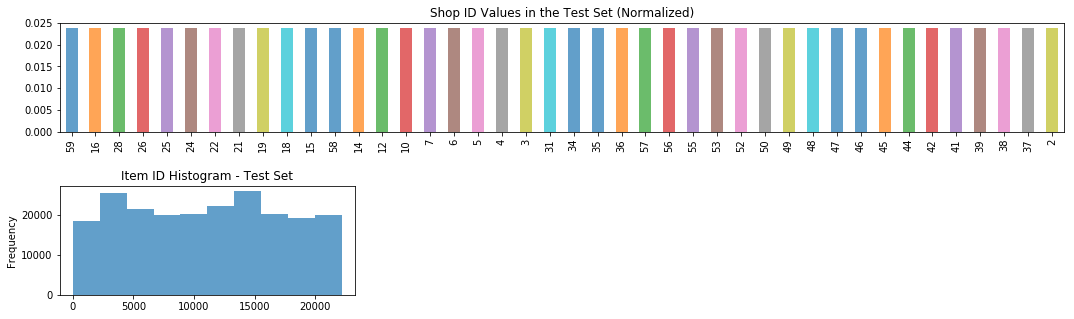

In [27]:
fig = plt.figure(figsize=(18,8))
plt.subplots_adjust(hspace=.5)

plt.subplot2grid((3,3), (0,0), colspan = 3)
test['shop_id'].value_counts(normalize=True).plot(kind='bar', alpha=0.7)
plt.title('Shop ID Values in the Test Set (Normalized)')

plt.subplot2grid((3,3), (1,0))
test['item_id'].plot(kind='hist', alpha=0.7)
plt.title('Item ID Histogram - Test Set')

plt.show()

1. The Shop Id's are evenly spread out, unlike the training set. The font size of labels quickly tells me that there are certain Shop Id's missing in the test set as the bars in the training set 'shop_id' plot were more tightly packed.
2. While item id's in the histogram are binned, the spikes are less in the test set. The test set is much smaller in shape than the training set, and naturally, the frequency values are significantly lower. It is tough to be draw more insights from this histogram.

It seems there might be some values of shop_id and item_id completely missing in the test set. Let's have a closer look and put some numbers or percentages to these missing values.

## Shops Analysis

In [28]:
shops_train = train['shop_id'].nunique()
shops_test = test['shop_id'].nunique()
print('Shops in Training Set: ', shops_train)
print('Shops in Test Set: ', shops_test)

Shops in Training Set:  60
Shops in Test Set:  42


However, this doesn't mean that the training set contains all of the shops present in the test set. For that, we need to see if every element of the test set is present in the training set. Let's write some simple code to see if the test set list is a subset of the training set list.

In [29]:
shops_train_list = list(train['shop_id'].unique())
shops_test_list = list(test['shop_id'].unique())

flag = 0
if(set(shops_test_list).issubset(set(shops_train_list))): 
    flag = 1
      
if (flag) : 
    print ("Yes, list is subset of other.") 
else : 
    print ("No, list is not subset of other.") 

Yes, list is subset of other.


### Duplicate Shops

Great, so all shops id's in the test set are also present in the training set. But there is an issue regarding duplicate shops that was talked about in the competition discussions. Let's have a look at the shops dataframe to identify this issue.

In [30]:
shops.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
shop_name,"!Якутск Орджоникидзе, 56 фран","!Якутск ТЦ ""Центральный"" фран","Адыгея ТЦ ""Мега""","Балашиха ТРК ""Октябрь-Киномир""","Волжский ТЦ ""Волга Молл""","Вологда ТРЦ ""Мармелад""","Воронеж (Плехановская, 13)","Воронеж ТРЦ ""Максимир""","Воронеж ТРЦ Сити-Парк ""Град""",Выездная Торговля,Жуковский ул. Чкалова 39м?,Жуковский ул. Чкалова 39м²,Интернет-магазин ЧС,"Казань ТЦ ""Бехетле""","Казань ТЦ ""ПаркХаус"" II","Калуга ТРЦ ""XXI век""","Коломна ТЦ ""Рио""","Красноярск ТЦ ""Взлетка Плаза""","Красноярск ТЦ ""Июнь""","Курск ТЦ ""Пушкинский""","Москва ""Распродажа""","Москва МТРЦ ""Афи Молл""",Москва Магазин С21,"Москва ТК ""Буденовский"" (пав.А2)","Москва ТК ""Буденовский"" (пав.К7)","Москва ТРК ""Атриум""","Москва ТЦ ""Ареал"" (Беляево)","Москва ТЦ ""МЕГА Белая Дача II""","Москва ТЦ ""МЕГА Теплый Стан"" II","Москва ТЦ ""Новый век"" (Новокосино)","Москва ТЦ ""Перловский""","Москва ТЦ ""Семеновский""","Москва ТЦ ""Серебряный Дом""","Мытищи ТРК ""XL-3""","Н.Новгород ТРЦ ""РИО""","Н.Новгород ТРЦ ""Фантастика""","Новосибирск ТРЦ ""Галерея Новосибирск""","Новосибирск ТЦ ""Мега""","Омск ТЦ ""Мега""","РостовНаДону ТРК ""Мегацентр Горизонт""","РостовНаДону ТРК ""Мегацентр Горизонт"" Островной","РостовНаДону ТЦ ""Мега""","СПб ТК ""Невский Центр""","СПб ТК ""Сенная""","Самара ТЦ ""Мелодия""","Самара ТЦ ""ПаркХаус""","Сергиев Посад ТЦ ""7Я""","Сургут ТРЦ ""Сити Молл""","Томск ТРЦ ""Изумрудный Город""","Тюмень ТРЦ ""Кристалл""","Тюмень ТЦ ""Гудвин""","Тюмень ТЦ ""Зеленый Берег""","Уфа ТК ""Центральный""","Уфа ТЦ ""Семья"" 2","Химки ТЦ ""Мега""",Цифровой склад 1С-Онлайн,"Чехов ТРЦ ""Карнавал""","Якутск Орджоникидзе, 56","Якутск ТЦ ""Центральный""","Ярославль ТЦ ""Альтаир"""
shop_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59


Using [Google translate API](https://pypi.org/project/googletrans/) and measuring pair wise Levenstein distance with a python [library](https://github.com/luozhouyang/python-string-similarity), I generated a matrix plot to observe similarity with the shop names

![Matrix Plot](https://i.imgur.com/wIvpacw.png) ![Threshold](https://i.imgur.com/cH94yt2.png)

Upon examing the above matrixes and 'similar' shop names, one observes that shops start with their city name! This can be a useful feature. Also, 'shop_id's 0 and 1 are the same as 57 and 58 respectively. The only difference is the Russian word 'фран' attached to both shops 0 and 1. Shops 10 and 11 have the exact same name excpet the last character ('?' vs '2'). These duplicates should be removed!

In [31]:
train.loc[train['shop_id'] == 0, 'shop_id'] = 57
test.loc[test['shop_id'] == 0, 'shop_id'] = 57

train.loc[train['shop_id'] == 1, 'shop_id'] = 58
test.loc[test['shop_id'] == 1, 'shop_id'] = 58

train.loc[train['shop_id'] == 10, 'shop_id'] = 11
test.loc[test['shop_id'] == 10, 'shop_id'] = 11

### Extracting City 

In [32]:
cities = shops['shop_name'].str.split(' ').map(lambda row: row[0])
cities.unique()

array(['!Якутск', 'Адыгея', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж',
       'Выездная', 'Жуковский', 'Интернет-магазин', 'Казань', 'Калуга',
       'Коломна', 'Красноярск', 'Курск', 'Москва', 'Мытищи', 'Н.Новгород',
       'Новосибирск', 'Омск', 'РостовНаДону', 'СПб', 'Самара', 'Сергиев',
       'Сургут', 'Томск', 'Тюмень', 'Уфа', 'Химки', 'Цифровой', 'Чехов',
       'Якутск', 'Ярославль'], dtype=object)

Upon careful observation, the city Yakutsk is represented as *'!Якутск'* and *'Якутск'*. We should make sure they are the same so when we label encode these city names, they will fall under the same cateogory. For reference, the english tranlation of the cities is below.

'!Yakutsk', 'Adygea', 'Balashikha', 'Volzhsky', 'Vologda', 'Voronezh', 'Outbound', 'Zhukovsky', 'Online', 'Kazan', 'Kaluga', 'Kolomna', 'Krasnoyarsk', 'Kursk', 'Moscow', 'Mytishchi', 'N.Novgorod', 'Novosibirsk', 'Omsk', 'RostovNaDonu', 'St.', 'Samara', 'Sergiev', 'Surgut', 'Tomsk', 'Tyumen', 'Ufa', 'Khimki', 'Digital', 'Chekhov', 'Yakutsk', 'Yaroslavl'

You will notice we only extract the St. from St. Petersburg but that's okay as we will label encode these categorical variables. 

In [33]:
shops['city'] = shops['shop_name'].str.split(' ').map(lambda row: row[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'

In [34]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit_transform(shops['city'])

array([29, 29,  0,  1,  2,  3,  4,  4,  4,  5,  6,  6,  7,  8,  8,  9, 10,
       11, 11, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14,
       15, 15, 16, 16, 17, 18, 18, 18, 19, 19, 20, 20, 21, 22, 23, 24, 24,
       24, 25, 25, 26, 27, 28, 29, 29, 30])

Great, that worked! Let's just add these codes to the shops dataframe. We can get rid of *'shop_name'* and *'city'* while preserving the *'shop_id'* and *'city_label'*

In [35]:
shops['city_label'] = le.fit_transform(shops['city'])
shops.drop(['shop_name', 'city'], axis = 1, inplace = True)
shops.head()

,shop_id,city_label
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2


## Items Analysis

Let's perform a similar train-test analysis for item_ids

In [36]:
items_train = train['item_id'].nunique()
items_test = test['item_id'].nunique()
print('Items in Training Set: ', items_train)
print('Items in Test Set: ', items_test)

Items in Training Set:  21806
Items in Test Set:  5100


There are a lot many more items in the training set than there are in the test set. However, this doesn't mean that the training set contains all of the items in the test set. For that, we need to see if every element of the test set is present in the training set. Let's write some simple code to achieve this.

In [37]:
items_train_list = list(train['item_id'].unique())
items_test_list = list(test['item_id'].unique())

flag = 0
if(set(items_test_list).issubset(set(items_train_list))): 
    flag = 1
      
if (flag) : 
    print ("Yes, list is subset of other.") 
else : 
    print ("No, list is not subset of other.") 

No, list is not subset of other.


Well then, this means there are certain items that are present in the test set but completely absent in the training set! Can we put a number to this to get an intuition?

In [38]:
len(set(items_test_list).difference(items_train_list))

363

There are 363 items that are present in the test set but completely absent in the training set. This doesn't mean that the sales prediction against those items must be zero as new items can be added to the market or we simply didn't possess the data for those items before. The fascinating questions pops though, how do you go about predicting them? 

Before we do that, let's find out more about the 5100 items in the test set. What categories to they belong to? What categories do we not have to make predictions in the test set for

In [39]:
categories_in_test = items.loc[items['item_id'].isin(sorted(test['item_id'].unique()))].item_category_id.unique()

In [40]:
# categories.loc[categories['item_category_id'].isin(categories_in_test)]
categories.loc[~categories['item_category_id'].isin(categories_in_test)].T

,1,4,8,10,13,14,17,18,32,39,46,48,50,51,52,53,59,66,68,80,81,82
item_category_name,Аксессуары - PS2,Аксессуары - PSP,Билеты (Цифра),Игровые консоли - PS2,Игровые консоли - PSP,Игровые консоли - PSVita,Игровые консоли - Прочие,Игры - PS2,"Карты оплаты (Кино, Музыка, Игры)",Кино - Blu-Ray 4K,Книги - Бизнес литература,Книги - Компьютерная литература,Книги - Открытки,Книги - Познавательная литература,Книги - Путеводители,Книги - Художественная литература,Музыка - Музыкальное видео,"Подарки - Открытки, наклейки","Подарки - Сертификаты, услуги",Служебные - Билеты,Чистые носители (шпиль),Чистые носители (штучные)
item_category_id,1,4,8,10,13,14,17,18,32,39,46,48,50,51,52,53,59,66,68,80,81,82


Using the same method, I generated a matrix plot to observe similarity with the shop names

![Category Matrix Plot](https://i.imgur.com/O5iTFj2.png) ![Category Matrix Threhsold](https://i.imgur.com/YZQrVRM.png)

### Grouping Common Categories and Extracting Sub-Categories

Upon examing the above matrices, one can spot a trend of main and sub-categories. These are in the dataframe, before the hyphen. Let's extract them!

In [41]:
le = preprocessing.LabelEncoder()

main_categories = categories['item_category_name'].str.split('-')
categories['main_category_id'] = main_categories.map(lambda row: row[0].strip())
categories['main_category_id'] = le.fit_transform(categories['main_category_id'])

# Some items don't have sub-categories. For those, we will use the main category as a sub-category
categories['sub_category_id'] = main_categories.map(lambda row: row[1].strip() if len(row) > 1 else row[0].strip())
categories['sub_category_id'] = le.fit_transform(categories['sub_category_id'])

In [42]:
categories.head()

,item_category_name,item_category_id,main_category_id,sub_category_id
0,PC - Гарнитуры/Наушники,0,0,29
1,Аксессуары - PS2,1,1,9
2,Аксессуары - PS3,2,1,10
3,Аксессуары - PS4,3,1,11
4,Аксессуары - PSP,4,1,13


Now, let's generate sales data for each shop and item present in the training set. We should do this for each month, as the final prediction is for the monthly count of sales for a particular shop and item

## Generating prodcuct of Shop-Item pairs for each month in the training data

In [43]:
train['date'] =  pd.to_datetime(train['date'], format='%d.%m.%Y')

In [44]:
from itertools import product

In [45]:
# Testing generation of cartesian product for the month of January in 2013

shops_in_jan = train.loc[train['date_block_num']==0, 'shop_id'].unique()
items_in_jan = train.loc[train['date_block_num']==0, 'item_id'].unique()
jan = list(product(*[shops_in_jan, items_in_jan, [0]]))

In [46]:
print(len(jan))

365175


As we can see, January 2013 contains 365,175 intersections of shops and items. Most of these will have no sales and we can verify this once we check our training set, which has been grouped by month, to see which 'items' x 'shops' combinations have a sale count associated with them. 

But before that, we need to generate this cartesian product for all 33 months in the training set. Before generating it for all months, I will generate it for February 2013, concatenate it with January 2013 and produce a dataframe.

In [47]:
# Testing generation of cartesian product for the month of February in 2013

shops_in_feb = train.loc[train['date_block_num']==1, 'shop_id'].unique()
items_in_feb = train.loc[train['date_block_num']==1, 'item_id'].unique()
feb = list(product(*[shops_in_feb, items_in_feb, [1]]))

In [48]:
print(len(feb))

375728


In [49]:
cartesian_test = []
cartesian_test.append(np.array(jan))
cartesian_test.append(np.array(feb))

In [50]:
cartesian_test

[array([[   59, 22154,     0],
        [   59,  2552,     0],
        [   59,  2554,     0],
        ...,
        [   45,   628,     0],
        [   45,   631,     0],
        [   45,   621,     0]]), array([[   50,  3880,     1],
        [   50,  4128,     1],
        [   50,  4124,     1],
        ...,
        [   28, 12885,     1],
        [   28, 12791,     1],
        [   28, 13433,     1]])]

Ran out of memory when trying to create a dataframe from january and february lists. The trick was to convert the lists to a numpy array. The handy numpy method 'vstack' will shape the cartesian_test object in the right manner, so we can convert it into a long form dataframe.

In [51]:
cartesian_test = np.vstack(cartesian_test)

In [52]:
cartesian_test_df = pd.DataFrame(cartesian_test, columns = ['shop_id', 'item_id', 'date_block_num'])

In [53]:
cartesian_test_df.head()

,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2552,0
2,59,2554,0
3,59,2555,0
4,59,2564,0


In [54]:
cartesian_test_df.shape

(740903, 3)

Viola! That worked. Time to extend this to all months using some neat code

In [55]:
from tqdm import tqdm_notebook

def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float16)
    df[int_cols]   = df[int_cols].astype(np.int16)
    
    return df

In [56]:
months = train['date_block_num'].unique()

In [57]:
cartesian = []
for month in months:
    shops_in_month = train.loc[train['date_block_num']==month, 'shop_id'].unique()
    items_in_month = train.loc[train['date_block_num']==month, 'item_id'].unique()
    cartesian.append(np.array(list(product(*[shops_in_month, items_in_month, [month]])), dtype='int32'))

In [58]:
cartesian_df = pd.DataFrame(np.vstack(cartesian), columns = ['shop_id', 'item_id', 'date_block_num'], dtype=np.int32)

In [59]:
cartesian_df.shape

(10913804, 3)

## Aggregating sales to a monthly level and clipping target variable

In [60]:
x = train.groupby(['shop_id', 'item_id', 'date_block_num'])['item_cnt_day'].sum().rename('item_cnt_month').reset_index()
x.head()

,shop_id,item_id,date_block_num,item_cnt_month
0,2,27,0,1.0
1,2,27,17,1.0
2,2,30,2,1.0
3,2,30,5,1.0
4,2,30,15,1.0


In [61]:
x.shape

(1609123, 4)

Now we need to merge our two dataframes. For the intersecting, we will simply put the values that exist in the dataframe x. For the remaining rows, we will sub in zero. Remember, the columns you want to merge on are the intersection of shop_id, item_id, and date_block_num

In [62]:
new_train = pd.merge(cartesian_df, x, on=['shop_id', 'item_id', 'date_block_num'], how='left').fillna(0)

By default, pandas fills the dataframes with NaN. That's why we use fillna to replace all NaN's with zero.

In [63]:
new_train['item_cnt_month'] = np.clip(new_train['item_cnt_month'], 0, 20)

In [64]:
del x
del cartesian_df
del cartesian
del cartesian_test
del cartesian_test_df
del feb
del jan
del items_test_list
del items_train_list
del train

In [65]:
new_train.sort_values(['date_block_num','shop_id','item_id'], inplace = True)
new_train.head()

,shop_id,item_id,date_block_num,item_cnt_month
114910,2,19,0,0.0
117150,2,27,0,1.0
120623,2,28,0,0.0
118316,2,29,0,0.0
114602,2,32,0,0.0


## Appending Test Set to Training Set

First, let's insert the date_block_num feature for the test set! Using insert method of pandas to place this new column at a specific index. This will allow us to concatenate the test set easily to the training set before we generate mean encodings and lag features

In [66]:
test.insert(loc=3, column='date_block_num', value=34)

In [67]:
test['item_cnt_month'] = 0

In [68]:
test.head()

,ID,shop_id,item_id,date_block_num,item_cnt_month
0,0,5,5037,34,0
1,1,5,5320,34,0
2,2,5,5233,34,0
3,3,5,5232,34,0
4,4,5,5268,34,0


In [69]:
new_train = new_train.append(test.drop('ID', axis = 1))

### Merging Shops, Items, Categories dataframes to add the city label, category_id, main category and sub-category feature

In [70]:
new_train = pd.merge(new_train, shops, on=['shop_id'], how='left')
new_train.head()

,shop_id,item_id,date_block_num,item_cnt_month,city_label
0,2,19,0,0.0,0
1,2,27,0,1.0,0
2,2,28,0,0.0,0
3,2,29,0,0.0,0
4,2,32,0,0.0,0


In [71]:
new_train = pd.merge(new_train, items.drop('item_name', axis = 1), on=['item_id'], how='left')
new_train.head()

,shop_id,item_id,date_block_num,item_cnt_month,city_label,item_category_id
0,2,19,0,0.0,0,40
1,2,27,0,1.0,0,19
2,2,28,0,0.0,0,30
3,2,29,0,0.0,0,23
4,2,32,0,0.0,0,40


In [72]:
new_train = pd.merge(new_train, categories.drop('item_category_name', axis = 1), on=['item_category_id'], how='left')
new_train.head()

,shop_id,item_id,date_block_num,item_cnt_month,city_label,item_category_id,main_category_id,sub_category_id
0,2,19,0,0.0,0,40,11,4
1,2,27,0,1.0,0,19,5,10
2,2,28,0,0.0,0,30,8,55
3,2,29,0,0.0,0,23,5,16
4,2,32,0,0.0,0,40,11,4


## Generating Lag Features and Mean-Encodings

In [73]:
def generate_lag(train, months, lag_column):
    for month in months:
        # Speed up by grabbing only the useful bits
        train_shift = train[['date_block_num', 'shop_id', 'item_id', lag_column]].copy()
        train_shift.columns = ['date_block_num', 'shop_id', 'item_id', lag_column+'_lag_'+ str(month)]
        train_shift['date_block_num'] += month
        train = pd.merge(train, train_shift, on=['date_block_num', 'shop_id', 'item_id'], how='left')
    return train

In [74]:
del items
del categories
del shops
del test

In [75]:
new_train = downcast_dtypes(new_train)

In [76]:
import gc
gc.collect()

21099

### Lag for Target Variable

In [77]:
%%time
new_train = generate_lag(new_train, [1,2,3,4,5,6,12], 'item_cnt_month')

CPU times: user 49.5 s, sys: 23.1 s, total: 1min 12s
Wall time: 1min 12s


### Lag for monthly Item-Target mean

In [78]:
%%time
group = new_train.groupby(['date_block_num', 'item_id'])['item_cnt_month'].mean().rename('item_month_mean').reset_index()
new_train = pd.merge(new_train, group, on=['date_block_num', 'item_id'], how='left')
new_train = generate_lag(new_train, [1,2,3,6,12], 'item_month_mean')
new_train.drop(['item_month_mean'], axis=1, inplace=True)

CPU times: user 43.9 s, sys: 26.6 s, total: 1min 10s
Wall time: 1min 10s


### Lag for monthly Shop-Target mean

In [79]:
%%time
group = new_train.groupby(['date_block_num', 'shop_id'])['item_cnt_month'].mean().rename('shop_month_mean').reset_index()
new_train = pd.merge(new_train, group, on=['date_block_num', 'shop_id'], how='left')
new_train = generate_lag(new_train, [1,2,3,6,12], 'shop_month_mean')
new_train.drop(['shop_month_mean'], axis=1, inplace=True)

CPU times: user 45.6 s, sys: 29.7 s, total: 1min 15s
Wall time: 1min 15s


### Lag for monthly Shop-Category mean

In [80]:
%%time
group = new_train.groupby(['date_block_num', 'shop_id', 'item_category_id'])['item_cnt_month'].mean().rename('shop_category_month_mean').reset_index()
new_train = pd.merge(new_train, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
new_train = generate_lag(new_train, [1, 2], 'shop_category_month_mean')
new_train.drop(['shop_category_month_mean'], axis=1, inplace=True)

CPU times: user 22.6 s, sys: 16.8 s, total: 39.4 s
Wall time: 39.4 s


### Lag for Monthly Main-Category mean

In [81]:
%%time
group = new_train.groupby(['date_block_num', 'main_category_id'])['item_cnt_month'].mean().rename('main_category_month_mean').reset_index()
new_train = pd.merge(new_train, group, on=['date_block_num', 'main_category_id'], how='left')

new_train = generate_lag(new_train, [1], 'main_category_month_mean')
new_train.drop(['main_category_month_mean'], axis=1, inplace=True)

CPU times: user 13.4 s, sys: 11.3 s, total: 24.7 s
Wall time: 24.7 s


### Lag for Monthly Sub-Category mean

In [82]:
%%time
group = new_train.groupby(['date_block_num', 'sub_category_id'])['item_cnt_month'].mean().rename('sub_category_month_mean').reset_index()
new_train = pd.merge(new_train, group, on=['date_block_num', 'sub_category_id'], how='left')

new_train = generate_lag(new_train, [1], 'sub_category_month_mean')
new_train.drop(['sub_category_month_mean'], axis=1, inplace=True)

CPU times: user 13.6 s, sys: 11.4 s, total: 25 s
Wall time: 25 s


In [83]:
new_train.tail()

,shop_id,item_id,date_block_num,item_cnt_month,city_label,item_category_id,main_category_id,sub_category_id,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,item_cnt_month_lag_12,item_month_mean_lag_1,item_month_mean_lag_2,item_month_mean_lag_3,item_month_mean_lag_6,item_month_mean_lag_12,shop_month_mean_lag_1,shop_month_mean_lag_2,shop_month_mean_lag_3,shop_month_mean_lag_6,shop_month_mean_lag_12,shop_category_month_mean_lag_1,shop_category_month_mean_lag_2,main_category_month_mean_lag_1,sub_category_month_mean_lag_1
11127999,45,18454,34,0.0,20,55,13,2,1.0,0.0,0.0,0.0,0.0,0.0,NaN,0.045441,0.023254,0.071411,0.590820,NaN,0.126709,0.128784,0.139038,0.137573,NaN,0.126831,0.074524,0.146973,0.196899
11128000,45,16188,34,0.0,20,64,14,42,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.022720,0.069763,NaN,NaN,NaN,0.126709,0.128784,NaN,NaN,NaN,0.094482,0.117126,0.237305,0.155884
11128001,45,15757,34,0.0,20,55,13,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.113647,0.069763,0.095215,0.250000,0.180054,0.126709,0.128784,0.139038,0.137573,0.181274,0.126831,0.074524,0.146973,0.196899
11128002,45,19648,34,0.0,20,40,11,4,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.045441,0.069763,0.166626,0.090881,NaN,0.126709,0.128784,0.139038,0.137573,NaN,0.083740,0.074097,0.224243,0.220825
11128003,45,969,34,0.0,20,37,11,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.068176,0.116272,0.023804,0.068176,0.119995,0.126709,0.128784,0.139038,0.137573,0.181274,0.128174,0.067444,0.224243,0.240967


### Add month feature!

In [84]:
new_train['month'] = new_train['date_block_num'] % 12

### Add Holiday feature!

In [85]:
holiday_dict = {
    0: 6,
    1: 3,
    2: 2,
    3: 8,
    4: 3,
    5: 3,
    6: 2,
    7: 8,
    8: 4,
    9: 8,
    10: 5,
    11: 4,
}

In [86]:
new_train['holidays_in_month'] = new_train['month'].map(holiday_dict)

### Russian Ruble Price per month!

In [87]:
# ruble_dollar = { 12: 33.675610, 13: 35.245171, 14: 36.195442, 15: 35.658811, 16: 34.918525, 17: 34.392044, 18: 34.684944, 19: 36.144526, 20: 37.951523, 21: 40.815324, 22: 46.257598, 23: 55.966912, 24: 63.676710, 25: 64.443511, 26: 60.261687, 27: 53.179035, 28: 50.682796, 29: 54.610770, 30: 57.155767, 31: 65.355082, 32: 66.950360, 33: 63.126499, 34: 65.083095, }

In [88]:
# new_train['ruble_value'] = new_train.date_block_num.map(ruble_dollar)

### Russian Stock Exchange Trading Volume (in Trillions)

In [89]:
moex = {
    12: 659, 13: 640, 14: 1231,
    15: 881, 16: 764, 17: 663,
    18: 743, 19: 627, 20: 692,
    21: 736, 22: 680, 23: 1092,
    24: 657, 25: 863, 26: 720,
    27: 819, 28: 574, 29: 568,
    30: 633, 31: 658, 32: 611,
    33: 770, 34: 723,
}

In [90]:
new_train['moex_value'] = new_train.date_block_num.map(moex)

In [91]:
new_train = downcast_dtypes(new_train)

# Training

In [92]:
import xgboost as xgb

In [93]:
new_train = new_train[new_train.date_block_num > 11]

# x_train = new_train[new_train.date_block_num < 33].drop(['item_cnt_month'], axis=1)
# y_train = new_train[new_train.date_block_num < 33]['item_cnt_month']

# x_valid = new_train[new_train.date_block_num == 33].drop(['item_cnt_month'], axis=1)
# y_valid = new_train[new_train.date_block_num == 33]['item_cnt_month']

# x_test = new_train[new_train.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [94]:
import gc
gc.collect()

56

In [95]:
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            df[col].fillna(0, inplace=True)         
    return df

new_train = fill_na(new_train)

In [96]:
def xgtrain():
    regressor = xgb.XGBRegressor(n_estimators = 5000,
                                 learning_rate = 0.01,
                                 max_depth = 10,
                                 subsample = 0.5,
                                 colsample_bytree = 0.5)
    
    regressor_ = regressor.fit(new_train[new_train.date_block_num < 33].drop(['item_cnt_month'], axis=1).values, 
                               new_train[new_train.date_block_num < 33]['item_cnt_month'].values, 
                               eval_metric = 'rmse', 
                               eval_set = [(new_train[new_train.date_block_num < 33].drop(['item_cnt_month'], axis=1).values, 
                                            new_train[new_train.date_block_num < 33]['item_cnt_month'].values), 
                                           (new_train[new_train.date_block_num == 33].drop(['item_cnt_month'], axis=1).values, 
                                            new_train[new_train.date_block_num == 33]['item_cnt_month'].values)
                                          ], 
                               verbose=True,
                               early_stopping_rounds = 50,
                              )
    return regressor_

In [97]:
%%time
regressor_ = xgtrain()

[0]	validation_0-rmse:1.16624	validation_1-rmse:1.15849
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:1.1619	validation_1-rmse:1.15471
[2]	validation_0-rmse:1.15849	validation_1-rmse:1.15117
[3]	validation_0-rmse:1.15488	validation_1-rmse:1.14692
[4]	validation_0-rmse:1.15079	validation_1-rmse:1.14293
[5]	validation_0-rmse:1.14681	validation_1-rmse:1.13899
[6]	validation_0-rmse:1.14306	validation_1-rmse:1.13576
[7]	validation_0-rmse:1.13851	validation_1-rmse:1.13225
[8]	validation_0-rmse:1.13465	validation_1-rmse:1.12911
[9]	validation_0-rmse:1.13051	validation_1-rmse:1.12544
[10]	validation_0-rmse:1.12627	validation_1-rmse:1.12159
[11]	validation_0-rmse:1.12301	validation_1-rmse:1.11846
[12]	validation_0-rmse:1.1196	validation_1-rmse:1.11478
[13]	validation_0-rmse:1.11615	validation_1-rmse:1.1112
[14]	validation_0-rmse:1.11236	validation_1-rmse:1.10795

In [98]:
predictions = regressor_.predict(new_train[new_train.date_block_num == 34].drop(['item_cnt_month'], axis = 1).values)

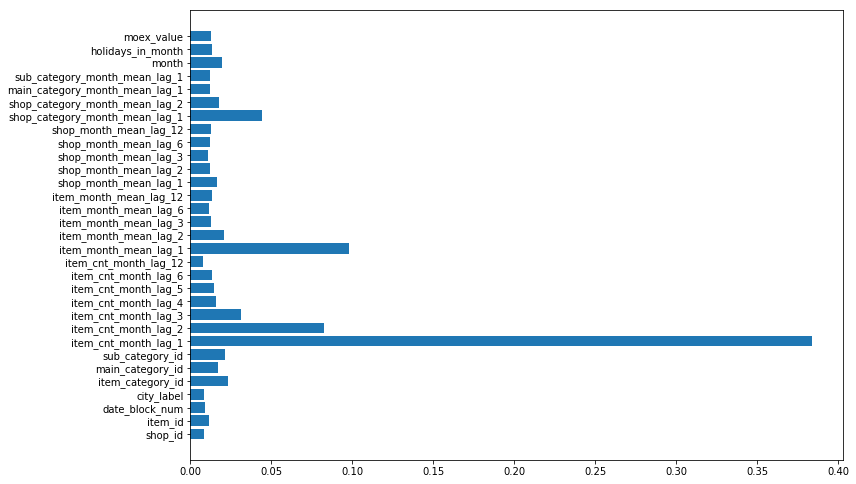

In [99]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 11.7,8.27

cols = new_train.drop('item_cnt_month', axis = 1).columns
plt.barh(cols, regressor_.feature_importances_)
plt.show()

In [100]:
submission['item_cnt_month'] = predictions

In [101]:
submission.to_csv('sales_faster_learn.csv', index=False)

In [102]:
from IPython.display import FileLinks
FileLinks('.')

./
  sales_faster_learn.csv
  __output__.json
  __notebook__.ipynb

Code to render Altair Charts

In [103]:
import json  # need it for json.dumps
from IPython.display import HTML

# Create the correct URLs for require.js to find the Javascript libraries
vega_url = 'https://cdn.jsdelivr.net/npm/vega@' + alt.SCHEMA_VERSION
vega_lib_url = 'https://cdn.jsdelivr.net/npm/vega-lib'
vega_lite_url = 'https://cdn.jsdelivr.net/npm/vega-lite@' + alt.SCHEMA_VERSION
vega_embed_url = 'https://cdn.jsdelivr.net/npm/vega-embed@3'
noext = "?noext"

altair_paths = {
    'vega': vega_url + noext,
    'vega-lib': vega_lib_url + noext,
    'vega-lite': vega_lite_url + noext,
    'vega-embed': vega_embed_url + noext
}

workaround = """
requirejs.config({{
    baseUrl: 'https://cdn.jsdelivr.net/npm/',
    paths: {paths}
}});
"""

# Define the function for rendering
def add_autoincrement(render_func):
    # Keep track of unique <div/> IDs
    cache = {}
    def wrapped(chart, id="vega-chart", autoincrement=True):
        """Render an altair chart directly via javascript.
        
        This is a workaround for functioning export to HTML.
        (It probably messes up other ways to export.) It will
        cache and autoincrement the ID suffixed with a
        number (e.g. vega-chart-1) so you don't have to deal
        with that.
        """
        if autoincrement:
            if id in cache:
                counter = 1 + cache[id]
                cache[id] = counter
            else:
                cache[id] = 0
            actual_id = id if cache[id] == 0 else id + '-' + str(cache[id])
        else:
            if id not in cache:
                cache[id] = 0
            actual_id = id
        return render_func(chart, id=actual_id)
    # Cache will stay defined and keep track of the unique div Ids
    return wrapped


@add_autoincrement
def render_alt(chart, id="vega-chart"):
    # This below is the javascript to make the chart directly using vegaEmbed
    chart_str = """
    <div id="{id}"></div><script>
    require(["vega-embed"], function(vegaEmbed) {{
        const spec = {chart};     
        vegaEmbed("#{id}", spec, {{defaultStyle: true}}).catch(console.warn);
    }});
    </script>
    """
    return HTML(
        chart_str.format(
            id=id,
            chart=json.dumps(chart) if isinstance(chart, dict) else chart.to_json(indent=None)
        )
    )

HTML("".join((
    "<script>",
    workaround.format(paths=json.dumps(altair_paths)),
    "</script>"
)))

In [104]:
alt.data_transformers.enable('default', max_rows=None)

DataTransformerRegistry.enable('default')

1. Plotting Ideas: Number of unique items sold each month
2. Sales graph, Revenue graph

In [105]:
train = pd.read_csv('../input/sales_train.csv')

In [106]:
alt_df = train.groupby('date_block_num')['item_cnt_day'].sum().rename('sum').reset_index()
alt_df.head(2)

,date_block_num,sum
0,0,131479.0
1,1,128090.0


In [107]:
# Generate a mapping for date_block_num to month and year.
dict_date_block_num = {0: 'January 2013', 1: 'February 2013', 2: 'March 2013', 3: 'April 2013',
4: 'May 2013', 5: 'June 2013', 6: 'July 2013', 7: 'August 2013',
8: 'September 2013', 9: 'October 2013', 10: 'November 2013', 11: 'December 2013',
12: 'January 2014', 13: 'February 2014', 14: 'March 2014', 15: 'April 2014',
16: 'May 2014', 17: 'June 2014', 18: 'July 2014', 19: 'August 2014',
20: 'September 2014', 21: 'October 2014', 22: 'November 2014', 23: 'December 2014',
24: 'January 2015', 25: 'February 2015', 26: 'March 2015', 27: 'April 2015',
28: 'May 2015', 29: 'June 2015', 30: 'July 2015', 31: 'August 2015',
32: 'September 2015', 33: 'October 2015'}

In [108]:
alt_df['date_block_num'].replace(dict_date_block_num, inplace=True)
alt_df.head(2)

,date_block_num,sum
0,January 2013,131479.0
1,February 2013,128090.0


In [109]:
split = alt_df['date_block_num'].str.split(" ", n = 1, expand = True) 

In [110]:
alt_df_two = alt_df.copy()
alt_df_two['month'] = split[0]
alt_df_two['year'] = split[1]
alt_df_two.head()

,date_block_num,sum,month,year
0,January 2013,131479.0,January,2013
1,February 2013,128090.0,February,2013
2,March 2013,147142.0,March,2013
3,April 2013,107190.0,April,2013
4,May 2013,106970.0,May,2013


In [111]:
chart1 = alt.Chart(alt_df_two).mark_area().encode(
    alt.X('date_block_num:T', axis = alt.Axis(labelAngle=-45), title='Time'),
    alt.Y('sum:Q', title='Items Sold'),
    alt.Color('month:N', scale=alt.Scale(scheme='category20'), sort = ['Januray'], title='Month')
).properties(width=1000, title='Kaggle Data Science Competition: Sales Prediction in Russian Stores')

In [112]:
alt.themes.enable('opaque')

ThemeRegistry.enable('opaque')

In [113]:
render_alt(chart1)

In [114]:
chart2 = alt.Chart(alt_df_two).mark_bar().encode(
    alt.X('year:N'),
    alt.Y('sum(sum):Q'),
    alt.Color('year:N')
).properties(width=1000)

In [115]:
render_alt(chart2)

In [116]:
alt_df_three = train.groupby(['date_block_num', 'shop_id'])['item_cnt_day'].sum().rename('sum').reset_index()
alt_df_three['date_block_num'].replace(dict_date_block_num, inplace=True)

split = alt_df_three['date_block_num'].str.split(" ", n = 1, expand = True) 
alt_df_three['month'] = split[0]
alt_df_three['year'] = split[1]

alt_df_three.head(2)

,date_block_num,shop_id,sum,month,year
0,January 2013,0,5578.0,January,2013
1,January 2013,1,2947.0,January,2013


In [117]:
chart3 = alt.Chart(alt_df_three).mark_rect().encode(
    alt.Y('month'),
    alt.X('shop_id:N'),
    alt.Color('mean(sum):Q')
)

chart4 = alt.Chart(alt_df_three).mark_rect().encode(
    alt.Y('year'),
    alt.X('shop_id:N'),
    alt.Color('mean(sum):Q')
)

chart = (chart3 & chart4)

In [118]:
render_alt(chart)